In [205]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [206]:
L = 7 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=1
coeff = 15

In [207]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))

In [208]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [209]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [210]:
def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**5))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**(5-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [226]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**5))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**(5-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [420]:
def R(i,theta):
    
    if i%15 == 0:
        return(exp_gate(0,theta))

    if i%15 == 1:
        return(exp_gate(1,theta))

    if i%15 == 2:
        return(exp_gate(2,theta))

    if i%15 == 3:
        return(exp_gate(3,theta))

    if i%15 == 4:
        return(exp_gate(4,theta))

    if i%15 == 5:
        return(exp_gate(5,theta))
    

    if i%15 == 6:
        return(rot_sigma_e(0,1,0,theta))


    if i%15 == 7:
        return(rot_sigma_e(0,2,0,theta))

    
    if i%15 == 8:
        return(rot_sigma_e(1,2,np.pi/2,theta))

    
    if i%15 == 9:
        return(rot_sigma_o(0,1,0,theta))


    if i%15 == 10:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%15 == 11:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    if i%15 == 12:
        return(rot_sigma_r(0,1,0,theta))


    if i%15 == 13:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%15 == 14:
        return(rot_sigma_r(1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%15 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%15 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%15 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%15 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())

    if i%15 == 4:
        return(exp_gate_der(4,theta)@exp_gate(4,theta).T.conj())
    
    if i%15 == 5:
        return(exp_gate_der(5,theta)@exp_gate(5,theta).T.conj())
    
    if i%15 == 6:
        return(-1j*sigma_e(0,1,0))

    
    if i%15 == 7:
        return(-1j*sigma_e(0,2,0))

    
    if i%15 == 8:
        return(-1j*sigma_e(1,2,np.pi/2))
     
    if i%15 == 9:
        return(-1j*sigma_o(0,1,0))

    
    if i%15 == 10:
        return(-1j*sigma_o(0,2,0))

    
    if i%15 == 11:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%15 == 12:
        return(-1j*sigma_r(0,1,0))

    
    if i%15 == 13:
        return(-1j*sigma_r(0,2,0))
    

    if i%15 == 14:
        return(-1j*sigma_r(1,2,np.pi/2))

In [421]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi
    return psi

In [422]:
r = 8
RR = 2*r+1

In [423]:
mat_exp = np.zeros((RR,RR),dtype = complex)

In [424]:
a = np.zeros(RR)
for i in range(RR):
    a[i] = 2*np.pi*(i-r)/RR

In [425]:
for i in range(RR):
    for j in range(RR):
        mat_exp[i][j] = np.exp(1j*a[i]*(j-r)/2)
print(det(mat_exp))

(1.2828870884492e-14+4.89620345612785e-24j)


In [426]:
def f(i,j,theta,a):
    
    array_i = np.zeros(len(theta))
    array_j = np.zeros(len(theta))
    
    array_i[i] = a
    array_j[j] = a

    theta_i = theta + array_i
    theta_j = theta + array_j
    
    psi_i = var_ansatz(theta_i,psi_0)
    psi_j = var_ansatz(theta_j,psi_0)
    
    return np.abs(np.conj(psi_i)@psi_j)**2
    
    

In [427]:
#theta = np.random.rand(coeff*N)
theta = np.random.rand(coeff*N)

In [428]:
f_a = np.zeros(RR)
for i in range(RR):
    f_a[i] = f(8,10,theta,a[i])

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [429]:
f_w = np.linalg.solve(mat_exp,f_a)

In [430]:
a_1 = np.linspace(-100,100,51)
exp_1 = np.zeros((51,RR),dtype = complex)

In [431]:
for i in range(51):
    for j in range(RR):
        exp_1[i][j] = np.exp(1j*a_1[i]*(j-r)/2)

In [432]:
f_a_1 = np.real(exp_1@f_w)
f_a_2 = np.zeros(len(a_1))
for i in range(len(a_1)):
    f_a_2[i] = f(8,10,theta,a_1[i])

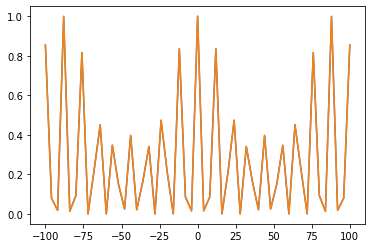

In [433]:
plt.plot(a_1,f_a_1,"-")
plt.plot(a_1,f_a_2,"-")
